# Generating Weekday and Weekend profiles

In [5]:
import polars as pl
import glob
import re
from pathlib import Path
import os
from datetime import datetime
from pathlib import Path
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

from kmodes.kprototypes import KPrototypes

import pandas as pd

In [6]:
pattern = f"{r'DATA/SM_DATA_average_min'}/*CH*.csv"
file_paths = glob.glob(pattern)

In [7]:
n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

n_samples = data_3d.shape[0]




Shape of the 3D array: (1464, 96, 1)


In [33]:
# Read the Excel file

file_path = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/Survey_Data/Survey_Data.xlsx"

# 1. Read the survey data
survey_df = pd.read_excel(file_path, skiprows=4, nrows=n_samples, header=None)

# Columns to extract as survey features: heat pump, EV, electrical heating of hot water
cols_to_extract = [144, 145, 146]

# Extract categorical strings and convert to category codes (integers)
survey_array1 = survey_df.iloc[:, cols_to_extract[0]].astype('category').cat.codes.to_numpy()
survey_array2 = survey_df.iloc[:, cols_to_extract[1]].astype('category').cat.codes.to_numpy()
survey_array3 = survey_df.iloc[:, cols_to_extract[2]].astype('category').cat.codes.to_numpy()

# Number of samples and timestamps in your existing data_3d
n_samples, n_timestamps, n_features = data_3d.shape

# Check length consistency
assert len(survey_array1) == n_samples
assert len(survey_array2) == n_samples
assert len(survey_array3) == n_samples

# 2. Flatten the numeric time series part (assuming original consumption feature is index 0)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# 3. Stack survey arrays to shape (n_samples, 3) as categorical features
survey_features = np.stack([survey_array1, survey_array2, survey_array3], axis=1)

# 4. Combine numeric + categorical features horizontally
combined_data = np.hstack([time_series_numeric, survey_features])

print(combined_data[:5, -3:])  # Print first 5 rows of the last 3 columns (survey features)


[[-1. -1.  1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1. -1.  0.]
 [ 0. -1.  1.]]


In [39]:


# 5. Specify the categorical feature column indices (the last 3 columns)
categorical_indices = list(range(combined_data.shape[1] - 3, combined_data.shape[1]))

# 6. Initialize and run K-Prototypes clustering
kproto = KPrototypes(n_clusters=3, init='Huang', verbose=1, max_iter=100,random_state=42)

clusters = kproto.fit_predict(combined_data, categorical=categorical_indices)

print("Cluster labels:")
print(clusters)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 258, ncost: 442.2466113686199
Run: 1, iteration: 2/100, moves: 30, ncost: 439.73116944258675
Run: 1, iteration: 3/100, moves: 10, ncost: 439.5419506904801
Run: 1, iteration: 4/100, moves: 0, ncost: 439.5419506904801
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 593, ncost: 468.36300625213573
Run: 2, iteration: 2/100, moves: 262, ncost: 452.63058012265344
Run: 2, iteration: 3/100, moves: 102, ncost: 448.27736196661823
Run: 2, iteration: 4/100, moves: 70, ncost: 445.41472784290295
Run: 2, iteration: 5/100, moves: 54, ncost: 443.7650278572379
Run: 2, iteration: 6/100, moves: 39, ncost: 442.3859269081222
Run: 2, iteration: 7/100, moves: 50, ncost: 440.3918971389547
Run: 2, iteration: 8/100, moves: 33, ncost: 439.6919406491982
Run: 2, iteration: 9/100, moves: 5, ncost: 439.67435983197265
Run: 2, iteration: 10/100,

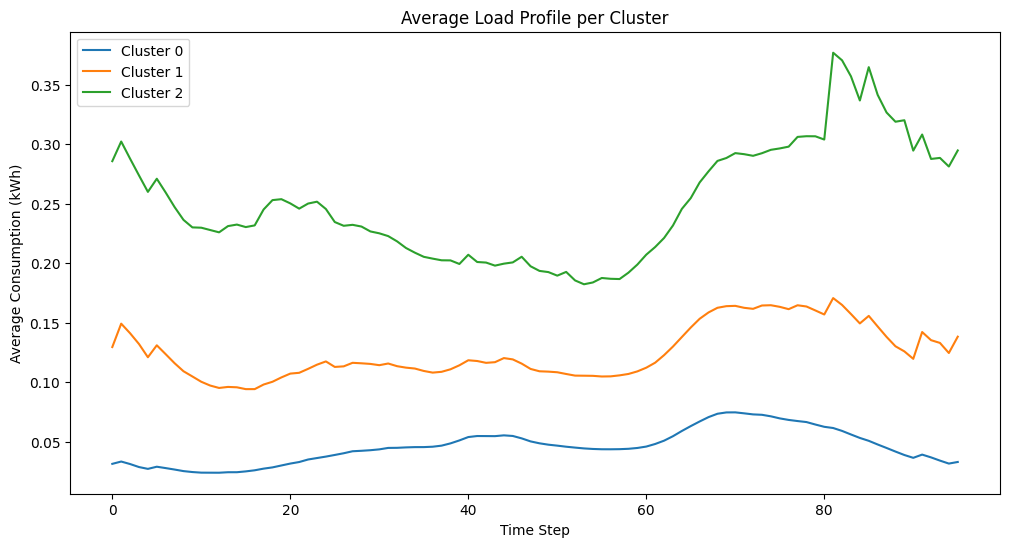

In [ ]:
unique_clusters = np.unique(clusters)

plt.figure(figsize=(12, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')

plt.title('Average Load Profile per Cluster')
plt.xlabel('Time Step')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.show()



In [48]:
# Assuming arrays: ev_array, hp_array, water_heating_array (binary 0/1 or categorical)
df = pd.DataFrame({
    'cluster': clusters,
    'EV': survey_array1,               
    'HeatPump': survey_array3,
    'WaterHeating': survey_array2
})

# Convert categorical columns to their integer codes or booleans for counting
df['EV_num'] = df['EV'].cat.codes  # or convert to bool: df['EV'] == 'Yes'
df['HeatPump_num'] = df['HeatPump'].cat.codes
df['WaterHeating_num'] = df['WaterHeating'].cat.codes

# Now groupby and sum counts per cluster
tech_counts = df.groupby('cluster')[['EV_num', 'HeatPump_num', 'WaterHeating_num']].sum().reset_index()

print(tech_counts)

# Count of each technology per cluster
tech_counts = df.groupby('cluster').agg({
    'EV': 'sum',
    'HeatPump': 'sum',
    'WaterHeating': 'sum'
}).reset_index()

print(tech_counts)

   cluster  EV_num  HeatPump_num  WaterHeating_num
0        0    -653           604              -879
1        1    -210           199              -285
2        2     -64            59               -91


TypeError: category type does not support sum operations

## Preparing Profiles for each day of the week

In [9]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/SM_DATA_cleaned")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_weekend(df, day_of_week):
    # Parse the timestamp column (assuming 'zeitpunkt' column exists)
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )

    df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([day_of_week]))
    
    # Extract time_of_day (hour, minute) as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day across all weekend days and average the energy column
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )

    return df

base_output_folder = Path("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/SM_DATA_weekly_normalized")



for day in [0, 1, 2, 3, 4, 5, 6]:

    day_folder = base_output_folder / f"SM_DATA_weekly_normalized_{day}"
    day_folder.mkdir(parents=True, exist_ok=True)

    for file_path in file_paths:
        df = pl.read_csv(file_path)
        day_avg = day_avg_preprocess_weekend(df, day)
        day_avg = normalize(day_avg)

        filename = os.path.basename(file_path)  # Original file name
        output_file = day_folder / filename  # Output path with same filename

        day_avg.write_csv(output_file)

## Weekday Clustering-->Difference between weekday and weekend

In [32]:
day_of_week = 2

pattern = f"DATA/SM_DATA_weekly_normalized/SM_DATA_weekly_normalized_{day_of_week}/*CH*.csv"
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)

data_3d = np.concatenate(data_list, axis=0)
print(f"Shape of the 3D array: {data_3d.shape}")

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)


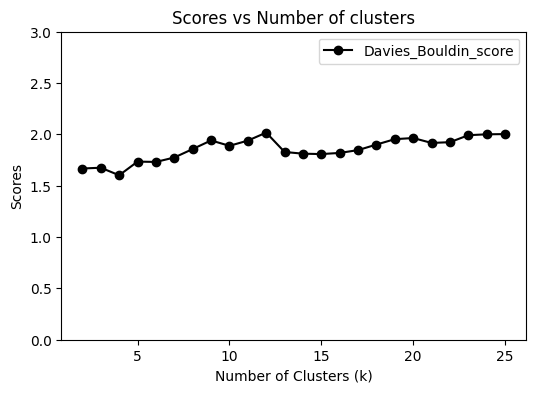

In [33]:
validation(data_3d)

In [34]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

3.928 --> 2.673 --> 2.557 --> 2.492 --> 2.471 --> 2.464 --> 2.461 --> 2.459 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 2.458 --> 


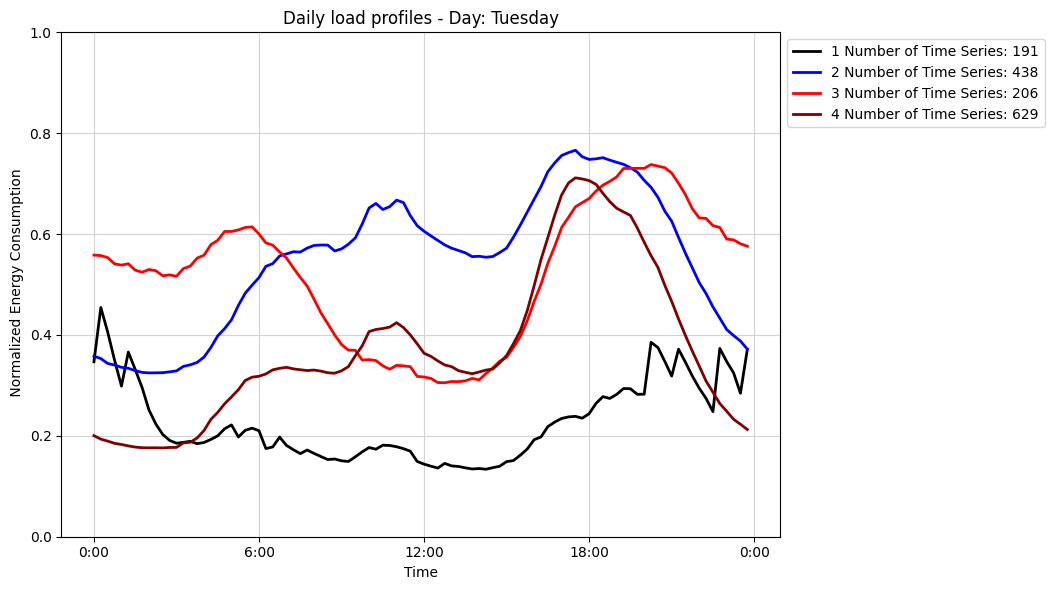

In [38]:
labels = ['0:00','6:00','12:00','18:00','0:00']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
        
    day_str = day_names[day_of_week -1]    
    plt.title(f'Daily load profiles - Day: {day_str}')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig("/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/Results/Plots_daily/" \
    "daily_evolution_"+ day_str +".png")
    plt.show()
    

plot_clusters_season()